# Solving ODEs with NeuralPDE.jl

From https://docs.sciml.ai/NeuralPDE/stable/tutorials/ode/

In [1]:
using NeuralPDE
using Lux
using OptimizationOptimisers
using OrdinaryDiffEq
using LinearAlgebra
using Random
using Plots
rng = Random.Xoshiro(0)

Random.Xoshiro(0xdb2fa90498613fdf, 0x48d73dc42d195740, 0x8c49bc52dc8a77ea, 0x1911b814c02405e8, 0x22a21880af5dc689)

## Solve ODEs
The true function: $u^{\prime} = cos(2 \pi t)$

In [2]:
model(u, p, t) = cospi(2t)

model (generic function with 1 method)

Prepare data

In [3]:
tspan = (0.0, 1.0)
u0 = 0.0
prob = ODEProblem(model, u0, tspan)

ODEProblem with uType Float64 and tType Float64. In-place: false
Non-trivial mass matrix: false
timespan: (0.0, 1.0)
u0: 0.0

Construct a neural network to solve the problem.

In [4]:
chain = Lux.Chain(Lux.Dense(1, 5, σ), Lux.Dense(5, 1))
ps, st = Lux.setup(rng, chain) |> f64

((layer_1 = (weight = [-0.04929668828845024; -0.3266667425632477; … ; -1.4946011304855347; -1.0391809940338135;;], bias = [-0.458548903465271, -0.8280583620071411, -0.38509929180145264, 0.32322537899017334, -0.32623517513275146]), layer_2 = (weight = [0.5656673908233643 -0.605137288570404 … 0.3129439055919647 0.22128699719905853], bias = [-0.11007555574178696])), (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

Solve the ODE as in `DifferentialEquations.jl`, just change the solver algorithm to `NeuralPDE.NNODE()`.

In [5]:
optimizer = OptimizationOptimisers.Adam(0.1)
alg = NeuralPDE.NNODE(chain, optimizer, init_params = ps)
sol = solve(prob, alg, maxiters=2000, saveat = 0.01)

┌ Warning: Mixed-Precision `matmul_cpu_fallback!` detected and Octavian.jl cannot be used for this set of inputs (C [Matrix{Float64}]: A [Base.ReshapedArray{Float32, 2, SubArray{Float32, 1, Vector{Float32}, Tuple{UnitRange{Int64}}, true}, Tuple{}}] x B [Matrix{Float64}]). Falling back to generic implementation. This may be slow.
└ @ LuxLib.Impl ~/.julia/packages/LuxLib/bYUJG/src/impl/matmul.jl:190


retcode: Success
Interpolation: Trained neural network interpolation
t: 0.0:0.01:1.0
u: 101-element Vector{Float64}:
  0.0
  0.010434387941232984
  0.02070509348095148
  0.030793077647978406
  0.040678452234755476
  0.05034051535473292
  0.059757798149638656
  0.06890812354716186
  0.0777686779082747
  0.08631609631418449
  ⋮
 -0.07836490950594578
 -0.0698418744905521
 -0.06092236405703448
 -0.051617905446235325
 -0.04194007134232463
 -0.0319004496146746
 -0.021510615166139887
 -0.010782103794821835
  0.000273612018954023

Comparing to the regular solver

In [6]:
sol2 = solve(prob, Tsit5(), saveat=sol.t)

retcode: Success
Interpolation: 1st order linear
t: 101-element Vector{Float64}:
 0.0
 0.01
 0.02
 0.03
 0.04
 0.05
 0.06
 0.07
 0.08
 0.09
 ⋮
 0.92
 0.93
 0.94
 0.95
 0.96
 0.97
 0.98
 0.99
 1.0
u: 101-element Vector{Float64}:
  0.0
  0.009993421557959134
  0.019947410479672478
  0.029822662260300302
  0.03958022071476466
  0.04918159908446656
  0.05858894195530296
  0.0677649690474175
  0.07667347363816583
  0.08527940825421805
  ⋮
 -0.07670552085637702
 -0.06779339219172714
 -0.05861083135542737
 -0.049195336960505105
 -0.039586192500697205
 -0.029824466350448206
 -0.019949141853139615
 -0.009995163933671121
 -1.7408033452440449e-6

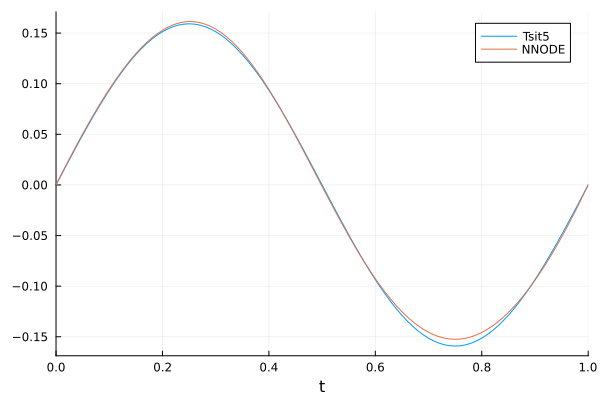

In [7]:
plot(sol2, label = "Tsit5")
plot!(sol.t, sol.u, label = "NNODE")

## Parameter estimation

In [8]:
using NeuralPDE, OrdinaryDiffEq, Lux, Random, OptimizationOptimJL, LineSearches, Plots
rng = Random.Xoshiro(0)

Random.Xoshiro(0xdb2fa90498613fdf, 0x48d73dc42d195740, 0x8c49bc52dc8a77ea, 0x1911b814c02405e8, 0x22a21880af5dc689)

NNODE only supports out-of-place functions

In [9]:
function lv(u, p, t)
    u₁, u₂ = u
    α, β, γ, δ = p
    du₁ = α * u₁ - β * u₁ * u₂
    du₂ = δ * u₁ * u₂ - γ * u₂
    [du₁, du₂]
end

lv (generic function with 1 method)

Generate data

In [10]:
tspan = (0.0, 5.0)
u0 = [5.0, 5.0]
true_p = [1.5, 1.0, 3.0, 1.0]
prob = ODEProblem(lv, u0, tspan, true_p)
sol_data = solve(prob, Tsit5(), saveat = 0.01)

t_ = sol_data.t
u_ = Array(sol_data)

2×501 Matrix{Float64}:
 5.0  4.82567  4.65308  4.48283  4.31543  …  1.01959   1.03094   1.04248
 5.0  5.09656  5.18597  5.26791  5.34212     0.397663  0.389887  0.382307

Define a neural network

In [11]:
n = 15
chain = Chain(Dense(1, n, σ), Dense(n, n, σ), Dense(n, n, σ), Dense(n, 2))
ps, st = Lux.setup(rng, chain) |> f64

((layer_1 = (weight = [-0.04929668828845024; -0.3266667425632477; … ; -1.3531280755996704; -0.2917589843273163;;], bias = [0.28568029403686523, -0.4209803342819214, -0.24613642692565918, -0.9429000616073608, -0.3618292808532715, 0.077278733253479, 0.9969245195388794, 0.7939795255661011, 0.45440757274627686, -0.4830443859100342, -0.6861011981964111, -0.3221019506454468, -0.5597391128540039, -0.15051674842834473, 0.9440881013870239]), layer_2 = (weight = [-0.08606008440256119 -0.2168799191713333 … -0.3507671356201172 0.07374405115842819; 0.24009405076503754 -0.2372819483280182 … 0.34944412112236023 -0.21207459270954132; … ; 0.3976286053657532 0.28444960713386536 … -0.32817620038986206 0.396392285823822; -0.07926429808139801 0.35875916481018066 … -0.03593128174543381 -0.28511112928390503], bias = [-0.065037302672863, 0.18384626507759094, 0.17181798815727234, -0.17310386896133423, 0.06428726017475128, 0.09600061178207397, -0.08703552931547165, 0.06890828162431717, -0.16194558143615723, -0.

Loss function

In [12]:
additional_loss(phi, θ) = sum(abs2, phi(t_, θ) .- u_) / size(u_, 2)

additional_loss (generic function with 1 method)

NNODE solver

In [13]:
opt = LBFGS(linesearch = BackTracking())
alg = NNODE(chain, opt, ps; strategy = WeightedIntervalTraining([0.7, 0.2, 0.1], 500), param_estim = true, additional_loss)

NeuralPDE.NNODE{Lux.Chain{@NamedTuple{layer_1::Lux.Dense{typeof(NNlib.σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Lux.Dense{typeof(NNlib.σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Lux.Dense{typeof(NNlib.σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_4::Lux.Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, Optim.LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.BackTracking{Float64, Int64}, Returns{Nothing}}, @NamedTuple{layer_1::@NamedTuple{weight::Matrix{Float64}, bias::Vector{Float64}}, layer_2::@NamedTuple{weight::Matrix{Float64}, bias::Vector{Float64}}, layer_3::@NamedTuple{weight::Matrix{Float64}, bias::Vector{Float64}}, layer_4::@NamedTuple{weight::Matrix{Float64}, bias::Vector{Float64}}}, Bool, NeuralPDE.WeightedIntervalTraining{Float64}, Bool, typeof(Main.var"##234".additional_loss), Vector{Any}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}}(Lux.Chain{@NamedTuple{layer_1::Lux.Dense{type

Solve the problem
Use `verbose=true` to see the fitting process

In [14]:
sol = solve(prob, alg, verbose = false, abstol = 1e-8, maxiters = 5000, saveat = t_)

retcode: Success
Interpolation: Trained neural network interpolation
t: 501-element Vector{Float64}:
 0.0
 0.01
 0.02
 0.03
 0.04
 0.05
 0.06
 0.07
 0.08
 0.09
 ⋮
 4.92
 4.93
 4.94
 4.95
 4.96
 4.97
 4.98
 4.99
 5.0
u: 501-element Vector{Vector{Float64}}:
 [5.0, 5.0]
 [4.82496970892158, 5.095955647662411]
 [4.6521589062323585, 5.184944805848066]
 [4.4819706223311595, 5.266626775493051]
 [4.314802361943825, 5.34071641578526]
 [4.151035563734231, 5.4069901927029305]
 [3.9910262511561023, 5.465290128491912]
 [3.8350973113992612, 5.51552553362733]
 [3.6835326578443532, 5.557672569577798]
 [3.5365733480457315, 5.591771839235821]
 ⋮
 [0.9596363247029993, 0.44583332654898555]
 [0.9693784015329001, 0.43695465977179104]
 [0.9792199400631807, 0.42831603105291194]
 [0.9891581662411264, 0.41991190098379594]
 [0.9991903310715378, 0.41173684621489137]
 [1.0093137110905706, 0.4037855568284616]
 [1.019525608806902, 0.39605283376354183]
 [1.029823353110678, 0.38853358629323154]
 [1.0402042996516614, 0.

See the fitted parameters

In [15]:
println(sol.k.u.p)

[1.4999941428339831, 0.9994788192557055, 2.9977500441382685, 0.9991939396487874]


Visualize the fit

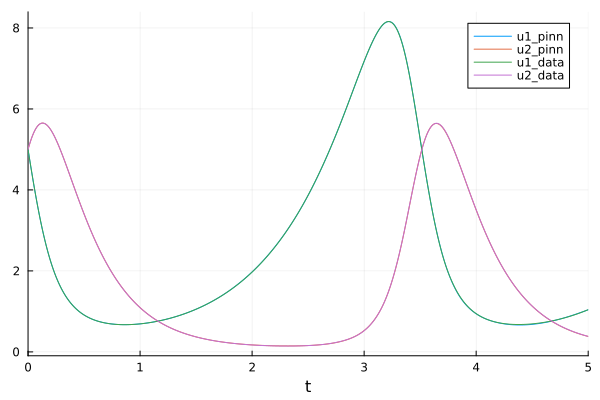

In [16]:
plot(sol, labels = ["u1_pinn" "u2_pinn"])
plot!(sol_data, labels = ["u1_data" "u2_data"])

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*